In [1]:
# Importing the required libraries.
import numpy as np
import pickle, zlib
from random import sample
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [7]:
# TO plot CDF of outlier ratios
def PlotCDF(Ana_df,collection_name):
    # Frequency
    Emp_df = Ana_df.groupby('EmpRatio')['EmpRatio'].agg('count').pipe(pd.DataFrame).rename(columns = {'EmpRatio': 'frequency'})
    Growth_df = Ana_df.groupby('GrowthRatio')['GrowthRatio'].agg('count').pipe(pd.DataFrame).rename(columns = {'GrowthRatio': 'frequency'})

    Emp_df['pdf'] = Emp_df['frequency'] / sum(Emp_df['frequency'])
    Growth_df['pdf'] = Growth_df['frequency'] / sum(Growth_df['frequency'])

    # CDF
    Emp_df['cdf'] = Emp_df['pdf'].cumsum()
    Emp_df = Emp_df.reset_index()

    Growth_df['cdf'] = Growth_df['pdf'].cumsum()
    Growth_df = Growth_df.reset_index()

    plt.plot(Emp_df['EmpRatio'], Emp_df['cdf'], label='Emp Ratio')
    plt.plot(Growth_df['GrowthRatio'], Growth_df['cdf'], label='Growth Ratio')
    plt.rcParams['font.size'] = '16'
    plt.title(collection_name.title())
    plt.xlabel('Outlier Ratio',fontsize=16)
    plt.ylabel('Cummulative Probability',fontsize=16)
    plt.legend(['Employment Type','Pace of Growth'])
    plt.grid(True)

    return plt
 


Collection: Development
            ArticleCount  EmpCount  GrowthCount  EmpRatio  GrowthRatio
DistrictId                                                            
3                      2         2            2  1.000000     1.000000
6                      3         2            2  0.666667     0.666667
7                      1         0            0  0.000000     0.000000
10                    21        14            6  0.666667     0.285714
12                     3         1            3  0.333333     1.000000
...                  ...       ...          ...       ...          ...
629                    7         4            6  0.571429     0.857143
630                    2         0            2  0.000000     1.000000
632                  107        96           95  0.897196     0.887850
635                    4         3            4  0.750000     1.000000
639                    1         1            0  1.000000     0.000000

[342 rows x 5 columns]


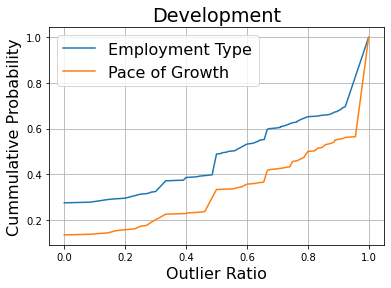


----Analysing interesting articles---
Emp Change:     DistrictId  ArticleCount  EmpCount  GrowthCount  EmpRatio  GrowthRatio
0         623            69        63           66  0.913043     0.956522
     District     NAME  EMP_2011
578       623  Madurai  Non Agri Fast
          ArticleCount
PredEmp               
Agri                54
Non Agri             6
Unemp                9
                                                                      Title   PredEmp
0                                      ‘Temple funds spent on govt. office’      Agri
1                                                Aadhaar enrolment launched      Agri
2                                   Town Hall Road gets paver block surface      Agri
3                                       Designing a Vaigai riverfront dream      Agri
4                                Meeting held on draft policy for start-ups      Agri
5     Corporation to conduct preliminary census of buildings in old Madurai      Agri
6           

In [13]:

# File paths and dataset names
FOLDER = 'drive/My Drive/ACT4D/'
datasets = ['dataset_agriculture', 'dataset_development', 'dataset_environment', 'dataset_industrialization', 'dataset_lifestyle']
PRED_DATASET = FOLDER+'Datasets/Split/Temporal/Prediction/Pred_dataset_'

# District Name id mapping 
DistrictName = pd.read_csv(FOLDER+'CSVs/district_names.csv')# Dataset is now stored in a Pandas Dataframe

PLOT =True # Plot graph or not
SAVE =False # Save the graph or not

MODE = 'Test'   # If test then only development dataset is run
# Selcet the collections or which you want to analyze the articles
SELECT = {'dataset_agriculture':0,'dataset_development':1,'dataset_environment':1,'dataset_industrialization':0,'dataset_lifestyle':0}

for datasetName in datasets:
    if MODE=='Test' and datasetName != 'dataset_development':
        continue;
    elif SELECT[datasetName]==0:
        continue;

    # Printing the collection name.
    collection_name = datasetName[8:]
    print('\nCollection:',collection_name.capitalize())

    # Loading the Predicted dataset and the model from the drive.

    file = open(PRED_DATASET+collection_name, 'rb')
    dataset = pickle.loads(zlib.decompress(pickle.load(file)))
    file.close()
    
    #Create Dataframe
    Pred_df = pd.DataFrame(dataset)
    Pred_df.columns = ['ArticleId','Title','Text','Keywords','Date','DistrictId','Emp','Growth','PredEmp','PredGrowth','EmpOut','GrowthOut']


    # Group by district and add Outlier Ratios to the dataframe for further Analysis
    Ana_df = Pred_df.copy()
    Ana_df = Ana_df.groupby('DistrictId').agg(ArticleCount = ('ArticleId', 'count'),EmpCount=('EmpOut', 'sum'), GrowthCount=('GrowthOut', 'sum'))
    Ana_df['EmpRatio'] = Ana_df['EmpCount']/Ana_df['ArticleCount']
    Ana_df['GrowthRatio'] = Ana_df['GrowthCount']/Ana_df['ArticleCount']
    print(Ana_df)

    #-- Graph: Plot CDF
    if PLOT:
        plt = PlotCDF(Ana_df,collection_name)

        # Save the graph
        if SAVE:
            plt.savefig(FOLDER+'Graphs/'+collection_name)
            plt.clf()
        else:
            plt.show()

    ###------------------------ Analysing interesting articles --------------------------###
    print('\n----Analysing interesting articles---')

    # Pandas display options
    pd.options.display.max_colwidth = 100  # set a value as your need
    pd.options.display.max_rows = 100  # set a value as your need

    # OPTIONS and VARIABLES/THRESHOLDS
    EMP =True      # Print emp outliers?
    GROW = True     # Print growth outliers?

    # SET Thresholds based on Collection, Quality of articles/districts needed.
    THRESH = 0.9    # Min. Outlier Ratio Threshold
    ECOUNT = 40     # Min. Number of Articles for a district to be displayed : Emp Outliers
    GCOUNT = 50     # Min. Number of Articles for a district to be displayed : Growth Outliers

    # District Analysis

    if EMP: # Emp Outlier
        # Print districts falling under preset thresholds
        EmpChange_df = Ana_df[(Ana_df['EmpRatio']>THRESH) & (Ana_df['EmpCount']>ECOUNT)]
        EmpChange_df = EmpChange_df.reset_index()
        print('Emp Change: ',EmpChange_df)
        
        #For each changing district print its articles
        Ecols=['Title','PredEmp']   # Columns to print
        for id in EmpChange_df['DistrictId']:
            listDf = Pred_df.loc[Pred_df['DistrictId']==id].reset_index() # List of articles of this district

            print(DistrictName.loc[DistrictName['District']==id],end=" ")   #Name of district and its Original Emp,Growth Types
            print(listDf['Growth'][0])

            # Print number of articles in each predicted emp class and list of all articles of the district
            print(listDf.groupby('PredEmp').agg(ArticleCount = ('ArticleId', 'count')))
            print(listDf[Ecols])


    if GROW: # Growth Outlier
        # Print districts falling under preset thresholds
        GrowthChange_df = Ana_df[(Ana_df['GrowthRatio']>THRESH) & (Ana_df['GrowthCount']>GCOUNT)]
        GrowthChange_df = GrowthChange_df.reset_index()
        print('Growth Change: ',GrowthChange_df)

        #For each changing district print its articles
        Gcols=['Title','PredGrowth']    # Columns to print
        for id in GrowthChange_df['DistrictId']:
            listDf = Pred_df.loc[Pred_df['DistrictId']==id].reset_index() # List of articles of this district
    
            print(DistrictName.loc[DistrictName['District']==id],end=" ")   #Name of district and its Original Emp,Growth Types
            print(listDf['Growth'][0])

            # Print number of articles in each predicted growth class and list of all articles of the district
            print(listDf.groupby('PredGrowth').agg(ArticleCount = ('ArticleId', 'count')))
            print(listDf[Gcols])








In [5]:
       # ! ls /content/drive/My\ Drive/ACT4D
    # dist_df['EmpRatio'] = pd.dataframe(Emp_df['EmpRatio'].values())
    # dist_df['Ecdf'] = Emp_df['cdf'].values()
    # dist_df['GrowthRatio'] = Growth_df['GrowthRatio'].values()
    # dist_df['Gcdf'] = Growth_df['cdf'].values()

    # print(dist_df.head())

    # dist_df.plot(x = ['EmpRatio', 'GrowthRatio'], y=['cdf','gcdf'])
    # Emp_df.plot(x = 'EmpRatio', y = ['cdf'], grid = True)
    # Growth_df.plot(x = 'GrowthRatio', y = ['cdf'], grid = True)


    # Pred_df['freq']=Pred_df.groupby(by='DistrictId')['DistrictId'].transform('count')
    # print(Pred_df)

    # GiniEmp = gini_coefficient(Pred_df['PredEmp'])
    # GiniGrwoth = gini_coefficienet(Pred_df['PredGrowth'])
    # pd.set_option('max_rows', 600)
    # print('Emp: ',giniEmp)
    # print('Growth: ',giniGrowth)